In [1]:
from ola_RNN import * 
from ola_trump import *
from ola_dataloader import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [2]:
%load_ext autoreload
%autoreload 2 

In [3]:
class Learner():
    def __init__(self, model, loss_fn, opt, data, lr):
        self.model, self.opt, self.loss_fn, self.data = model, opt, loss_fn, data
        self._lr     = opt.param_groups[0]['lr']
        
    @property
    def lr(self):
        return self._lr
    
    @lr.setter
    def lr(self,lr):
        self._lr = lr
        for param_group in self.opt.param_groups:
            param_group['lr'] = lr        

In [4]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN2,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, combined)
        self.relu2   = nn.ReLU(combined)
        
        self.o3      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.relu2(output)
        
        output   = self.o3(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hd_sz  = hidden_size
        self.in_sz  = input_size
        self.out_sz = output_size
        
        combined = input_size+hidden_size
        
        self.h1      = nn.Linear(combined, hidden_size)               

        self.o1      = nn.Linear(combined, combined)
        self.relu    = nn.ReLU(combined)

        self.o2      = nn.Linear(combined, input_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)    
        
        hidden   = self.h1(combined)
        hidden   = torch.tanh(hidden)
        
        output   = self.o1(combined)
        output   = self.relu(output)
        
        output   = self.o2(output)
        output   = self.softmax(output)
        return output, hidden

    def initHidden(self,bs):
        return cuda(torch.zeros(bs,self.hd_sz))

In [5]:
def fit_rnn(learn, epoches, valid_loss=[], itters=math.inf, cb=None):
    hidden = learn.model.initHidden(15)    
    for epoch in range(epoches):
        for xb, yb in iter(learn.data.train_dl):   
            learn.model.train()
            output, hidden, loss = rnn_forward(learn,hidden,xb,yb)
            if loss != 0:
                loss.backward()
                learn.opt.step()
                learn.opt.zero_grad()
            if (learn.data.train_dl.nb_itters()%100==0): valid_loss.append(get_valid_rnn(learn,itters=30))  
            if learn.data.train_dl.nb_itters() == itters: break
    return learn, hidden, valid_loss

def rnn_forward(learn,hidden,xb,yb):
    learn.model.train()
    if xb[0,0,1].item() == 1: hidden = learn.model.initHidden(xb.shape[0])                   
    loss = 0 
    for char in range(xb.shape[1]):
        x,y = xb[:,char],yb[:,char]
        x,y,hidden = unpad_rnn(x,y,hidden)

        if x is None: break        
        output,hidden = learn.model.forward(x,hidden)
        loss += learn.loss_fn(output,y)                

    if loss == 0: return None,hidden.detach(),loss 
    return output,hidden.detach(),loss/(char+1)

def unpad_rnn(x,y,hidden):
    idx = (y != 0).nonzero()
    if idx.shape[0] < 2: return None,y,hidden
    else: idx = idx.squeeze()
    return x[idx],y[idx],hidden[idx]

def get_valid_rnn(learn,itters=30):
    print(f"""getting validation""")    
    learn.model.eval()
    tot_loss = 0 
    with torch.no_grad():
        hidden = learn.model.initHidden(15)
        for xb,yb in iter(learn.data.valid_dl): 
            output, hidden, loss = rnn_forward(learn,hidden,xb,yb)  
            if loss != 0: tot_loss += loss.item()/xb.shape[0]
            if learn.data.valid_dl.nb_itters() == itters: 
                return tot_loss/learn.data.valid_dl.nb_itters()
        
    return tot_loss/learn.data.valid_dl.nb_itters()


def generate_seq(model,Data,sql,symbol='^'):
    model.eval()
    with torch.no_grad():
        hidden = model.initHidden(1)
        result = symbol
        for i in range(sql):
            x = cuda(onehencode(symbol,Data.encoder))
            output, hidden = model.forward(x,hidden)        
            hidden = hidden.detach()
            
            prob     = np.exp(output[0].cpu().numpy())
            cum_prob = np.cumsum(prob)
            idx      = np.where(cum_prob - random.random() > 0)[0][0]
            symbol   = Data.decoder[idx]
            result  += symbol
    model.train()

In [6]:
bs  = 15
sql = 30 
lr  = 0.0005 

data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,sql,shuffle=False)

model  = cuda(RNN(len(data.decoder), 150, 1))
opt    = optim.RMSprop(model.parameters(), lr)

model2 = cuda(RNN2(len(data.decoder), 150, 1))
opt2   = optim.RMSprop(model2.parameters(), lr)

learn  = Learner(model, nn.NLLLoss(), opt, data, lr=lr)
learn2 = Learner(model2, nn.NLLLoss(), opt2, data, lr=lr)

In [8]:
start = time.time()
learn, hidden, valid_loss   = fit_rnn(learn,1,valid_loss=[])
print(f"""finished first took {time.time() - start} seconds""")
learn2, hidden, valid_loss2 = fit_rnn(learn2,1,valid_loss=[])
print(f"""finished second took {time.time() - start} seconds""")

getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting validation
getting vali

In [ ]:
print(len(valid_loss),len(valid_loss2))

0.12858297136094837 0.1240135145187378


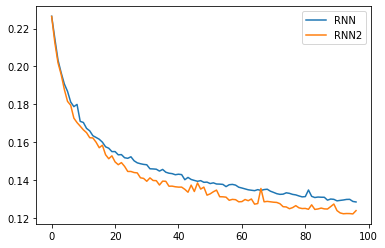

In [10]:
plt.figure()
plt.plot([x for x in range(len(valid_loss))],valid_loss,label='RNN')
plt.plot([x for x in range(len(valid_loss2))],valid_loss2,label='RNN2')       
plt.legend()                                                               

print(valid_loss[-1],valid_loss2[-1])

In [ ]:
plt.figure()
plt.plot(valid_loss2[0:-1])
print(valid_loss2[-1])

In [14]:
def generate_seq(model,Data,sql,symbol='^'):
    model.eval()
    with torch.no_grad():
        hidden = model.initHidden(1)
        result = symbol
        for i in range(sql):
            x = cuda(onehencode(symbol,Data.encoder))
            output, hidden = model.forward(x,hidden)        
            hidden = hidden.detach()
            
            prob     = np.exp(output[0].cpu().numpy())
            cum_prob = np.cumsum(prob)
            idx      = np.where(cum_prob - random.random() > 0)[0][0]
            symbol   = Data.decoder[idx]
            result  += symbol
    model.train()
    print(result)

In [15]:
generate_seq(learn.model,learn.data,200)

^Core leasticilatecter!! AmOr€ucorde…€ht.co/TOTNES_on€whs€an€" put 2016"€🇺🇸"€ NEwj’st to ceed on Press that tectice… https://t.co/PEgnyOJOz€€€€€€€ ksire “strees? !stort it have the Demoor want to Milin


In [20]:
generate_seq(learn2.model,learn.data,200)

^Nane out I keep Soney. I happlayed @FoxNebNB€€€€ https://t.co/MVDM5OhLV€€€"€ S"€,0 AND getf€illets to wampain Borrmatic gats. We noad Kor Adey who be imaraments, on #Framp2016€€€m€entHofs!€. We ase th
